---
layout: default
categories: logisticRegression
title: "Logistic Regression - Implementation"
permalink: /ML7.5/
order: 7.5
comments: true
---

In [1]:
%pylab --no-import-all inline
plt.rcParams["mathtext.fontset"] = "cm"

Populating the interactive namespace from numpy and matplotlib


# Logistic regression implementation

## Pytorch
Pytorch implementation of logistic regression is extremely similar to that of linear regression. The two main differences is that the linear regression layer is wrapped by a non-linearity function and that the loss function used is the [Cross Entropy Loss](https://en.wikipedia.org/wiki/Cross_entropy).

In [2]:
import torch

Once again the steps for training a model in Pytorch as defined in [Pytorch documentation](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py) are

1. Load Dataset
2. Make Dataset Iterable
3. Create Model Class
4. Instantiate Model Class
5. Instantiate Loss Class
6. Instantiate Optimizer Class
7. Train Model

In this case we are using the famous [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) which consists of a series of images of handwritten digits. The logistic regression model will need to correctly identify the digit represented in the image.

The `dsets` module has access to a number of datasets, `MNIST` is one of them. By setting the `download` parameter to `True`, the whole datasets is downloaded locally.

In [3]:
import torchvision.datasets as dsets

train_dataset = dsets.MNIST(root='./data', train=True, download=False)
test_dataset = dsets.MNIST(root='./data', train=False)

the dataset is made of a series of `tuples` containing two objects, a `PIL` image and the number it represents

In [4]:
train_dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FBAC20B02E8>, 5)

As you can see from the `PIL` object  `repr` the images are $28 \times 28$ pixels in size.

A sample of 100 images in the dataset show us that the images are low-res grayscale hadrwitten digits with different styles.

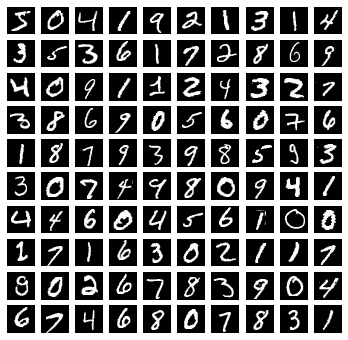

In [5]:
sample_imgs = next(zip(*train_dataset))[:10**2]
fig, axes = plt.subplots(10, 10, figsize=(6, 6))

for ax, smp in zip(axes.ravel(), sample_imgs):
    ax.imshow(smp, cmap='gray')
    ax.axis('off')

The dataset needs to be transformed to tensor in order for Pytorch to be able to process it. To do that we use the `transforms` module and `ToTensor()` function. 

Doing that after loading the dataset would be a bit more difficult so, in practice, this step is usually performed contextually to the data load, using the `transform` argument.

In [6]:
import torchvision.transforms as transforms

train_dataset = dsets.MNIST(
    root='./data', 
    train=True, 
    download=False, 
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]))

test_dataset = dsets.MNIST(
    root='./data', 
    train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]))

In the `transform` step we also specified that the tensor needs to be normalized. This avoids exploding or vanishing gradients problems. Once again the normalization strategy adopted is standardization

$$
z = \frac{x-\mu}{\sigma}
$$

We need to pass the mean $\mu$ and standard deviation $\sigma$ to the `Normalize` function inside `tuple`s. The first `tuple` contains the mean of each channel in the figure and the second `tuple` contains the standard deviation of each channel in the figure and the second. In this case we only have one channel.

Now the images in the dataset have been converted to tensors and their values normalized. Since our input are square images of $28 \times 28$ pixels and they only have one channel, the tensor $x_i \in \mathbb{R}^{1 \times 28 \times 28}$ or $x_i \in \mathbb{R}^{784}$

In [7]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

We can now define here some hyperparameters that will come in handy later

In [8]:
batch_size = 100
epochs = 3000 / (len(train_dataset) / batch_size)
input_dim = np.prod(train_dataset[0][0].shape)
output_dim = 10
alpha = 0.001

the train and test datasets are wrapped in a `DataLoader` that provide functions to iterate over the dataset, split it into patches and shuffle it.

In [9]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

For logistic regression we just need a linear model that we will wrap into a non linearity function like ReLU or softmax. So as for linear regression, our model is just made of a `Linear` object instantiated with the input and output dimensions that in this case are $28 \times 28 = 784$ for the input and $10$ for the output (we want to identify handwritten digits).

In [10]:
model = torch.nn.Linear(input_dim, output_dim)

The loss function $\mathcal{L}$ adopted in logistic regression is the [Cross Entropy Loss](https://en.wikipedia.org/wiki/Cross_entropy). 

$$
\mathcal{L} = - \left(y \log(p)+(1-y)\log(1-p) \right)
$$

In [11]:
criterion = torch.nn.CrossEntropyLoss()

The optimizer we are using is [Stochastic Gradient Descent](https://www.google.com/search?q=stochastic+gradient+descent&oq=stockas&aqs=chrome.2.69i57j0i10l5j0i10i395l2j0i10j0i10i395.1729j1j7&sourceid=chrome&ie=UTF-8) with a preset learning rate $\alpha$

In [12]:
optimizer = torch.optim.SGD(model.parameters(), lr=alpha)

The training loop is a bit more complex than the linear regression example

In [13]:
from torch.autograd import Variable

iteration = 0
for epoch in range(int(epochs)):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, 28 * 28))
        labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        iteration += 1
        if iteration % 500 == 0:
            # calculate Accuracy
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = Variable(images.view(-1, 28*28))
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total+= labels.size(0)
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
                correct+= (predicted == labels).sum()
            accuracy = 100 * correct/total
            print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iteration, loss.item(), accuracy))

Iteration: 500. Loss: 0.78566575050354. Accuracy: 82.4800033569336.
Iteration: 1000. Loss: 0.5676836371421814. Accuracy: 86.30000305175781.
Iteration: 1500. Loss: 0.5241549015045166. Accuracy: 87.52999877929688.
Iteration: 2000. Loss: 0.4447768032550812. Accuracy: 88.37999725341797.
Iteration: 2500. Loss: 0.510481059551239. Accuracy: 88.94999694824219.
Iteration: 3000. Loss: 0.4202028214931488. Accuracy: 89.38999938964844.
